<br>

# <center>COVID-19 'Vaccine' Safety and Harm Mitigation</center></h1>

<br>

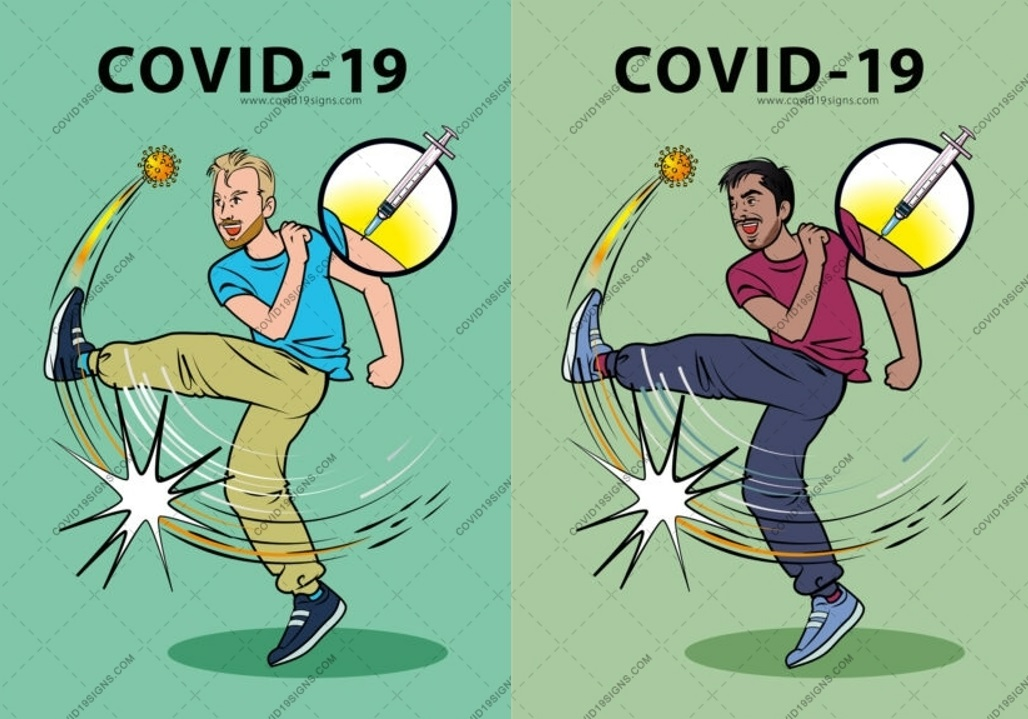

### As the cartoons show, injections against COVID-19 are being heavily touted by those in authority and by cheesy poster artists.  But are these products that were forced out the door at 'warp speed' both safe and effective?  This jupyter notebook looks at safety and harm mitigation.



<br>

### I Safety

<br>

First the importation of the necessary Python libraries:

In [706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import itertools
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
warnings.filterwarnings('ignore')

Thanks to the United States federal government's 'Vaccine Adverse Events Reporting System' [(VAERS)](https://vaers.hhs.gov/index.html), we will make two comparisons pertaining to the case and death loads attributed to the COVID-19 injections administered under the CDC's 'emergency use authorization' on or before July 09, 2021:

1) For all vaccines over three decades to see if there is a rise in risk appetite since December 10, 2020, the start date of the 'emergency use authorization'.

2) For Non-COVID-19 vs COVID-19 associated events since December 10, 2020, the date cited above.

<br>

### I A) Long Range View

<br>

The first of these two comparisons requires the loading of thirty-two years worth of data from exactly that many separate files and the futher processing of records in which death was reported.  The four-pane visualization will show a year-over-year view of case-load and deaths followed by a pair of cummulative graphs of same.  This encompasses the entire time frame that VAERS has been in existence.

In [707]:
df_case_30_year = pd.DataFrame({})
for i in range(1990,2022):
    df_case_30_year = df_case_30_year.append(pd.read_csv(str(i)+"VAERSData.csv", low_memory=False), ignore_index=True)
df_case_30_year.shape

(1130127, 35)

In [708]:
df_case_30_year['VAX_DATE'] = pd.to_datetime(df_case_30_year['VAX_DATE'])
df_case_30_year = df_case_30_year[df_case_30_year['VAX_DATE']>= pd.Timestamp(1990, 1, 1)]

In [709]:
df_case_30_year['VAX_DATE'].min(), df_case_30_year['DIED'].unique()

(Timestamp('1990-01-01 00:00:00'), array([nan, 'Y'], dtype=object))

In [710]:
df_case_load_tally = pd.DataFrame(df_case_30_year.groupby('VAX_DATE').size()).rename(columns = {0: 'cases'})
df_case_load_tally['cumulative'] = [df_case_load_tally['cases'][:i+1].sum() for i in \
                                    range(len(df_case_load_tally['cases']))]

In [711]:
df_death_load_tally = pd.DataFrame(df_case_30_year[df_case_30_year['DIED']==df_case_30_year['DIED']]\
                                   .groupby('VAX_DATE').size()).rename(columns = {0: 'cases'})
df_death_load_tally['cumulative'] = [df_death_load_tally['cases'][:i+1].sum() for i in \
                                    range(len(df_death_load_tally['cases']))]

In [712]:
df_case_30_year['vax year'] = df_case_30_year['VAX_DATE'].dt.year

In [713]:
df_yearly = df_case_30_year.groupby('vax year')['VAERS_ID'].count()

In [714]:
df_yearly_dead = df_case_30_year[df_case_30_year['DIED']==df_case_30_year['DIED']]
df_yearly_dead.shape

(9132, 36)

In [715]:
df_dead_yoy = df_yearly_dead.groupby('vax year')['VAERS_ID'].count()
df_dead_yoy.tail()

vax year
2017      75
2018      81
2019      78
2020     287
2021    4918
Name: VAERS_ID, dtype: int64

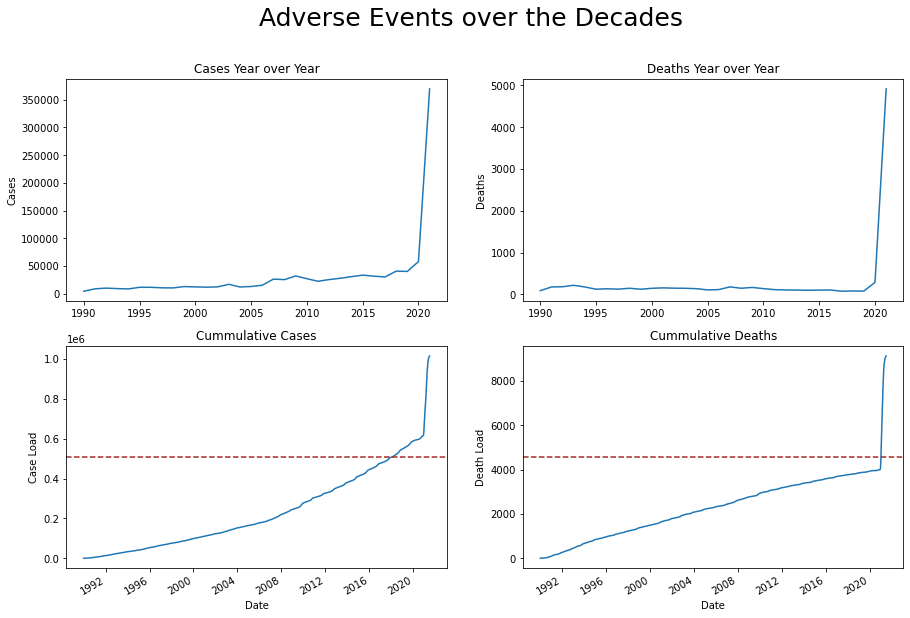

In [716]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)
fig.suptitle("Adverse Events over the Decades", fontsize=25)

plt.subplot(2,2,3)
df_case_load_tally['cumulative'].plot()
plt.axhline(y = df_case_load_tally['cumulative'].max()/2, color = 'brown',\
            linestyle='--')
plt.title('Cummulative Cases')
plt.ylabel('Case Load')
plt.xlabel('Date')

plt.subplot(2,2,4)
df_death_load_tally['cumulative'].plot()
plt.axhline(y = df_death_load_tally['cumulative'].max()/2, color = 'brown',\
            linestyle='--')
plt.title('Cummulative Deaths')
plt.ylabel('Death Load')
plt.xlabel('Date')

plt.subplot(2,2,1)
df_yearly.plot()
plt.title('Cases Year over Year')
plt.ylabel('Cases')
plt.xlabel('')

plt.subplot(2,2,2)
df_dead_yoy.plot()
plt.title('Deaths Year over Year')
plt.ylabel('Deaths')
plt.xlabel('')

print()
print()

The dotted line in the bottom two frames is for half of the curve's maximum, thereby illustrating that a majority of the overall cases and cases of death have taken place within a narrow window compared to the entire 30+ year perspective.

<br>

### I B) Recent History

<br>

Now for the second comparison which requires six files covering two calendar years of data appended and then merged into a single dataframe followed by the exclusion of cases before December 10, 2020.  Here too, incidents of patient death need to be made visible.  Additionally, COVID-related 'vaccinations' have to be separated from non-COVID.

In [717]:
df_case_2021 = pd.read_csv('2021VAERSData.csv', low_memory=False)
df_case_2020 = pd.read_csv('2020VAERSData.csv', low_memory=False)
df_symptoms_2021 = pd.read_csv('2021VAERSSYMPTOMS.csv', low_memory=False)
df_symptoms_2020 = pd.read_csv('2020VAERSSYMPTOMS.csv', low_memory=False)
df_vax_2021 = pd.read_csv('2021VAERSVAX.csv')
df_vax_2020 = pd.read_csv('2020VAERSVAX.csv')

In [718]:
df_case = df_case_2021.append(df_case_2020, ignore_index=True)
df_symptoms = df_symptoms_2021.append(df_symptoms_2020, ignore_index=True)
df_vax = df_vax_2021.append(df_vax_2020, ignore_index=True)
df = pd.merge(pd.merge(df_case, df_vax, on='VAERS_ID'), df_symptoms, on='VAERS_ID')
df['VAX_DATE'] = pd.to_datetime(df['VAX_DATE'])
df = df[df['VAX_DATE']>= pd.Timestamp(2020, 10, 10)]
df = df.reindex([i for i in range(df.shape[0])])

In [719]:
df['VAX_NAME'] = df['VAX_NAME'].map(lambda x:  x if (x==x) else 'unknown')

In [720]:
COVID_vaccines= [value for value in df['VAX_NAME'].unique() if re.search("COVID", value)]
df['flag'] = df.apply(lambda x: int(x['VAX_NAME'] in COVID_vaccines), axis=1)

In [721]:
df_case_load_COVID = pd.DataFrame(df[df['flag'] == 1].groupby('VAX_DATE').size()).rename(columns = {0: 'cases'})
df_case_load_COVID['cumulative'] = [df_case_load_COVID['cases'][:i+1].sum() for i in \
                                    range(len(df_case_load_COVID['cases']))]

df_case_load_not_COVID = pd.DataFrame(df[df['flag'] == 0].groupby('VAX_DATE').size()).rename(columns = {0: 'cases'})
df_case_load_not_COVID['cumulative'] = [df_case_load_not_COVID['cases'][:i+1].sum() for i in \
                                    range(len(df_case_load_not_COVID['cases']))]

In [722]:
df_death_load_COVID = pd.DataFrame(df[df['flag'] == 1].reindex_like(df)[df['DIED'].astype(bool)].\
                                   groupby('VAX_DATE').size()).rename(columns = {0: 'deaths'})
df_death_load_COVID['cumulative'] = [df_death_load_COVID['deaths'][:i+1].sum()\
                                    for i in range(len(df_death_load_COVID['deaths']))]

df_death_load_not_COVID = pd.DataFrame(df[df['flag'] == 0].reindex_like(df)[df['DIED'].astype(bool)].\
                                   groupby('VAX_DATE').size()).rename(columns = {0: 'deaths'})
df_death_load_not_COVID['cumulative'] = [df_death_load_not_COVID['deaths'][:i+1].sum()\
                                    for i in range(len(df_death_load_not_COVID['deaths']))]

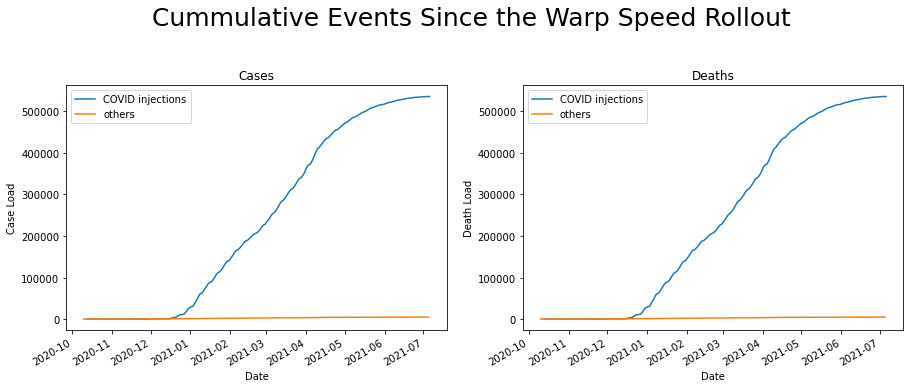

In [723]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(5)
fig.suptitle("Cummulative Events Since the Warp Speed Rollout", fontsize=25, y=1.10)
fig.subplots_adjust(hspace=1.0)

plt.subplot(1,2,1)
plt.title ('Cases')
df_case_load_COVID['cumulative'].plot(label = 'COVID injections')
df_case_load_not_COVID['cumulative'].plot(label = 'others')
plt.ylabel('Case Load')
plt.xlabel('Date')
plt.legend()


plt.subplot(1,2,2)
plt.title ('Deaths')
df_death_load_COVID['cumulative'].plot(label='COVID injections')
df_death_load_not_COVID['cumulative'].plot(label='others')
plt.ylabel('Death Load')
plt.xlabel('Date')
plt.legend()

print()

Needless-to-say the COVID-19 events shown in blue in both charts dominate all others shown in tan.  (The phrase 'warp speed' was borrowed from the US governmental and political jargon concerning to the COVID 'vaccine' intitiative.)

It could not be more clear that these simple graphs do not make the same case that is made by the cartoons at the top of the page.  Still, a more complete analysis is needed to properly contextualize all of this information, sobering as it is.  But even with this 10,000 foot view, it is evident that harm mitigation is needed as it relates to keeping some patients away from these products whose safety record is questionable at best.

<br>

### II Harm Mitigation

<br>

Looking at recent history, the public has been told that they will need multiple shots and the number that was settled upon was two.  For this reason, it is worthwhile to look at patients who experienced severe side effects to assess their likelyhood of dying as a warning against getting further injections.

<br>

### II A) Selecting the Relevant Data

<br>

The first order of business is to remove from the analysis, records that are unrelated to the COVID-19 shots.

In [724]:
df['VAX_NAME'] = df['VAX_NAME'].map(lambda x:  x if (x==x) else 'none')
COVID_vaccines= [value for value in df['VAX_NAME'].unique() if re.search("COVID", value)]
df['flag'] = df.apply(lambda x: int(x['VAX_NAME'] in COVID_vaccines), axis=1)
df_COVID = df[df['flag']==1]
df_COVID.index=[i for i in range(df_COVID.shape[0])]

<br>

### II B) Wrangling up the Data

<br>

Now to create a variable to contain the list of columns with symptoms:

In [725]:
symptom_fields = list(df_COVID.columns[list(df_COVID.columns).index('SYMPTOM1'):list(df_COVID.columns)\
                                       .index('SYMPTOM5')+1:2])

...and replace the null entries therein with 'none'.

In [726]:
df_COVID[symptom_fields] = df_COVID[symptom_fields].applymap(lambda x: 'none' if x != x else x)
df_COVID[symptom_fields].head().style.hide_index()

SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
Dysphagia,Epiglottitis,none,none,none
Anxiety,Dyspnoea,none,none,none
Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,none
Dizziness,Fatigue,Mobility decreased,none,none
Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,none


Each record represents an individual patient.  Therefor, the same symptom should not show up twice in the same record.  Here is a function for checking for duplication within individual records:

In [727]:
def dupe_check():
    df_array = df_COVID[symptom_fields].to_numpy()
    for i in range (len(df_array)):
        for j in range (5):
            if (df_array[i][j] != 'none') and (df_array[i][j] in df_array[i][:j]):
                print(i, df_array[i][:j+1])

In [728]:
dupe_check()

11770 ['Headache' 'Hypoaesthesia' 'Hypoaesthesia']
46917 ['Cellulitis' 'Exposure via contaminated device' 'Injection site erythema'
 'Injection site erythema']
48737 ['Blood pressure measurement' 'Dyspnoea' 'Dyspnoea']
48740 ['Heart rate' 'Heart rate increased' 'Oxygen saturation'
 'Oxygen saturation decreased' 'Oxygen saturation decreased']
133925 ['COVID-19' 'Drug ineffective' 'Respiratory failure' 'Respiratory failure']
160950 ['Erythema' 'Erythema']
160953 ['Nitrite urine absent' 'Oedema peripheral' 'Oedema peripheral']
160955 ['Pyrexia' 'Rash' 'Rash erythematous' 'Rash erythematous']


There is, in infact, duplication within certain records.  Correcting this:

In [729]:
df_array = df_COVID[symptom_fields].to_numpy()
for i in range (len(df_array)):
    for j in range (5):
        if (df_array[i][j] != 'none') and (df_array[i][j] in df_array[i][:j]):
            df_COVID.loc[df_COVID.index==i, symptom_fields[j]] = 'none'

Checking again:

In [730]:
dupe_check()

No duplications.  The remedy worked.

Having cleaned up the symptom fields, this is a good time to assess the frequency of the full range of symptoms among the living and the dead.

In [731]:
symptoms_live = reduce(lambda x,y : x.append(y), \
                       [df_COVID[df_COVID['DIED']!=df_COVID['DIED']][symptom_fields]['SYMPTOM'+str(i)] \
                        for i in range(1,6)], pd.Series({}, \
                       dtype=np.int64)).value_counts().drop('none')

In [732]:
symptoms_dead = reduce(lambda x,y : x.append(y), \
                       [df_COVID[df_COVID['DIED']==df_COVID['DIED']][symptom_fields]['SYMPTOM'+str(i)] \
                        for i in range(1,6)], pd.Series({}, \
                       dtype=np.int64)).value_counts().drop(['none', 'Death'])

In [733]:
symptoms_live[:10]

Headache               77977
Pyrexia                63760
Fatigue                63103
Chills                 59531
Pain                   57591
Dizziness              46910
Nausea                 45848
Pain in extremity      37324
Injection site pain    29433
Arthralgia             24789
dtype: int64

In [734]:
symptoms_dead[:10]

Dyspnoea                    653
COVID-19                    507
SARS-CoV-2 test positive    440
Cardiac arrest              435
Unresponsive to stimuli     396
Resuscitation               343
Fatigue                     316
Asthenia                    310
Pyrexia                     307
Vomiting                    265
dtype: int64

Not surprisingly, patients who did not make it have worse symptoms.  Failure of the 'vaccine' to fullfill its assigned errand also shows in the rows marked 'COVID-19' and 'SARS-CoV-2 test positive' (although the latter generally refers to a PCR test that has a high rate of false positivity).  Sady, we are talking about patients who took the oft-repeated advice and were dead shortly thereafter.

Looking at some other datafields:

In [735]:
df_COVID['AGE_YRS'].describe(), df_COVID[['AGE_YRS']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   AGE_YRS  521609 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


(count    521609.000000
 mean         49.098938
 std          18.105788
 min           0.080000
 25%          35.000000
 50%          49.000000
 75%          63.000000
 max         119.000000
 Name: AGE_YRS, dtype: float64,
 None)

The only problem with the age is the null values which we will impute using the mean age.

In [736]:
df_COVID['AGE_YRS'].mean()

49.09893772921862

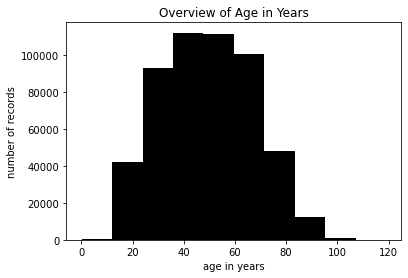

In [737]:
plt.hist(df_COVID['AGE_YRS'], color='black')
plt.title('Overview of Age in Years')
plt.xlabel('age in years')
plt.ylabel('number of records')
cleanframe=1

In [738]:
df_COVID.loc[df_COVID['AGE_YRS'] != df_COVID['AGE_YRS'], 'AGE_YRS'] = df_COVID['AGE_YRS'].mean()

Concerning sex:

In [739]:
df_COVID['SEX'].value_counts(), df_COVID[['SEX']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SEX     535494 non-null  object
dtypes: object(1)
memory usage: 8.2+ MB


(F    385705
 M    144678
 U      5111
 Name: SEX, dtype: int64,
 None)

Where a value is missing, substitute 'U' for unknown:

In [740]:
df_COVID.loc[df['SEX'] != df['SEX'], 'SEX'] = 'U'

In [741]:
df_COVID['SEX'].value_counts()

F    367161
M    136668
U     31665
Name: SEX, dtype: int64

One hot coding the sex:

In [742]:
dummies = pd.get_dummies(df_COVID['SEX'])
df_COVID[dummies.columns] = dummies
df_COVID.drop(['SEX', 'U'], axis=1, inplace=True)

In [743]:
'M' in df_COVID.columns, 'F' in df_COVID.columns, 'U' in df_COVID.columns, 'SEX' in df_COVID.columns

(True, True, False, False)

In [744]:
df_COVID['HOSPITAL'].value_counts(), df.shape[0]

(Y    47740
 Name: HOSPITAL, dtype: int64,
 569333)

The cell below will change the field for hospitalization into 1's and 0's (instead of values of 'Y' and null).

In [745]:
df_COVID['HOSPITAL'] = (df_COVID['HOSPITAL']==df_COVID['HOSPITAL']).astype(np.int64)

In [746]:
df_COVID['HOSPITAL'].value_counts(), df.shape[0]

(0    487754
 1     47740
 Name: HOSPITAL, dtype: int64,
 569333)

'NUMDAYS' refers to the time that went by since the injection was administered.

In [747]:
df_COVID['NUMDAYS'].describe(), df_COVID[['NUMDAYS']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   NUMDAYS  521140 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


(count    521140.00000
 mean          4.94527
 std          12.96528
 min           0.00000
 25%           0.00000
 50%           1.00000
 75%           4.00000
 max         204.00000
 Name: NUMDAYS, dtype: float64,
 None)

In [748]:
df_COVID["NUMDAYS"].fillna(value=df["NUMDAYS"].mean(), inplace=True)

In [749]:
df_COVID[['NUMDAYS']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   NUMDAYS  535494 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


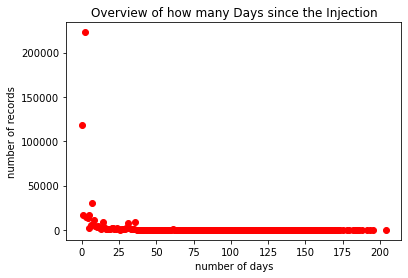

In [750]:
plt.scatter(df_COVID['NUMDAYS'].unique(), df_COVID.groupby('NUMDAYS').size(), color='red')
plt.title('Overview of how many Days since the Injection')
plt.xlabel('number of days')
plt.ylabel('number of records')
cleanframe=1

In [751]:
df_COVID[['DIED']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DIED    8403 non-null   object
dtypes: object(1)
memory usage: 8.2+ MB


Again transforming a column into values of 1 and 0:

In [752]:
df_COVID['DIED'] = (df_COVID['DIED']==df_COVID['DIED']).astype(np.int64)

In [753]:
df_COVID[['DIED']].info(), df_COVID['DIED'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   DIED    535494 non-null  int64
dtypes: int64(1)
memory usage: 8.2 MB


(None,
 0    527091
 1      8403
 Name: DIED, dtype: int64)

Looking at number of days in the hospital:

In [754]:
df_COVID[['HOSPDAYS']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HOSPDAYS  35831 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


And filling with 0's where the patient was not in the hospital.

In [755]:
df_COVID['HOSPDAYS'].fillna(0, inplace=True)

In [756]:
df_COVID[['HOSPDAYS']].info(), df_COVID['HOSPDAYS'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HOSPDAYS  535494 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


(None,
 count    535494.000000
 mean          2.196508
 std         432.135621
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max       99999.000000
 Name: HOSPDAYS, dtype: float64)

Implausibly large numbers of days need to be replaced with the mean.

In [757]:
df_COVID[df_COVID['HOSPDAYS']>=120]['HOSPDAYS'][:5]

329116      999.0
448551    99999.0
448552    99999.0
448553    99999.0
448554    99999.0
Name: HOSPDAYS, dtype: float64

In [758]:
df_COVID.loc[df_COVID['HOSPDAYS']>=120,'HOSPDAYS'] = np.nan

In [759]:
df_COVID['HOSPDAYS'].fillna(value = df_COVID['HOSPDAYS'].mean(), inplace=True)

In [760]:
df_COVID[['HOSPDAYS']].info(), df_COVID['HOSPDAYS'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535494 entries, 0 to 535493
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   HOSPDAYS  535494 non-null  float64
dtypes: float64(1)
memory usage: 8.2 MB


(None,
 count    535494.000000
 mean          0.327010
 std           1.988104
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max         104.000000
 Name: HOSPDAYS, dtype: float64)

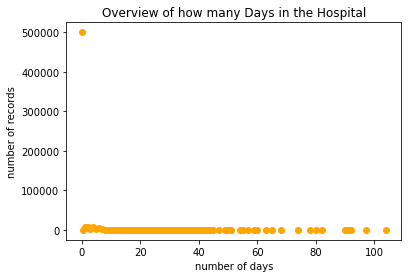

In [761]:
plt.scatter(df_COVID['HOSPDAYS'].unique(), df_COVID.groupby('HOSPDAYS').size(), color='orange')
plt.title('Overview of how many Days in the Hospital')
plt.xlabel('number of days')
plt.ylabel('number of records')
cleanframe=1

<br>

### II C) Drilling Down to High Risk Scenarios

<br>

In the cell below, separate fields are created for patients who got 'vaccinated' but wound up with in either a medical emergency or a long hospital stay.

In [762]:
Cardiac = reduce(lambda a,b: (a) | (df_COVID['SYMPTOM' + str(b)] == 'Cardiac arrest'), range(1,6), 0)
Resuscitation = reduce(lambda a,b: (a) | (df_COVID['SYMPTOM' + str(b)] == 'Resuscitation'), range(1,6), 0)

df_COVID.loc[:,'Cardiac'] = Cardiac.astype(int)

df_COVID.loc[:,'Resuscitation'] = Resuscitation.astype(int)

df_COVID['long hospital stay'] = (df_COVID['HOSPDAYS'] > 10).astype(int)

Making a separate dataframe for high-risk patients:

In [763]:
df_at_risk=df_COVID[(df_COVID['long hospital stay'] == 1 ) | Resuscitation | Cardiac]
df_at_risk.index = [i for i in range(df_at_risk.shape[0])]

In [764]:
df_at_risk.shape

(4339, 57)

<br>

### II D) Prior Health Problems

<br>

Looking at the field for current illnesses, it is clear that text processing will be needed to make it useful.

In [765]:
df_at_risk['CUR_ILL'].value_counts()[:10]

None                                                                                      653
none                                                                                      324
No                                                                                         81
unknown                                                                                    77
Unknown                                                                                    51
None.                                                                                      43
Possible episode of colitis with diarrhea/loose stools, managed conservatively at home     36
NONE                                                                                       35
None known                                                                                 28
none reported                                                                              23
Name: CUR_ILL, dtype: int64

In [766]:
df_at_risk['CUR_ILL'].fillna(value='none', inplace=True)

Wrangling the information in the column marked 'CUR_ILL' to include only actual illnesses.

In [767]:
current_illnesses = [value for value in list(df_COVID['CUR_ILL'].unique()) if not(re.search("None", str(value))\
                    or re.search("none", str(value)) or re.search("Na ", str(value)) or re.search("No ", str(value))\
                    or re.search(" no ", str(value)))]

In [768]:
current_illnesses[5:10]

['Bacterial Upper Respiratory infection(2 weeks ago), husband tested COVID + <1week ago',
 'Constipation, indigestion, not on day of vaccine',
 'Covid Positive Mid November',
 'Covid 19, date of symptom onset 11/28/2020',
 'was on Amoxicillin for tooth abscess (last dose 1 week ago)']

In [769]:
df_at_risk['prior condition'] = [int(value in current_illnesses)\
                                for value in df_at_risk['CUR_ILL'].values]

In [770]:
df_at_risk['cardiac patient'] = [int(bool\
                                (re.search("cardiac", str(value)) or re.search("heart", str(value)) or\
                                 re.search("Heart", str(value)) or\
                                 re.search("Cardiac", str(value)))) \
                                 for value in df_at_risk['CUR_ILL']]

In [771]:
df_at_risk['COVID patient'] = [int(bool\
                                (re.search("COVID", str(value)) or re.search("SARS", str(value)) or\
                                 re.search("covid", str(value)) or\
                                 re.search("Covid", str(value)))) \
                                 for value in df_at_risk['CUR_ILL']]

In [772]:
df_at_risk['chronic patient'] = [int(bool\
                                (re.search("lung", str(value)) or re.search("cancer", str(value)) or\
                                 re.search("tumor", str(value)) or\
                                 re.search("surgery", str(value)))) \
                                 for value in df_at_risk['CUR_ILL']]

<br>

### II E) Predicting Morbidity with a Statistical Model

<br>

A combination of datafields was selected in order to provide the most accurate statistical model.

In [773]:
x_cols = df_at_risk[['Cardiac', 'long hospital stay', 'Resuscitation', 'AGE_YRS', 'NUMDAYS', 'M', 'F',\
                     'HOSPDAYS']]
X_train, X_test, y_train, y_test = train_test_split(x_cols, df_at_risk['DIED'], test_size=0.33)
scaler_object = StandardScaler()
X_train = scaler_object.fit_transform(X_train)
X_test = scaler_object.transform(X_test)
classifier = svm.SVC(kernel = 'linear', gamma = 'auto', C = 2, probability=True)
classifier.fit(X_train, y_train)
regressor = LogisticRegression()
y_pred = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8009776536312849

<br>

### II F) Sizing up the Model against the Test Set

<br>

In [774]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1009
           1       0.73      0.51      0.60       423

    accuracy                           0.80      1432
   macro avg       0.78      0.72      0.74      1432
weighted avg       0.79      0.80      0.79      1432



<br>

## ROC CURVE

<br>

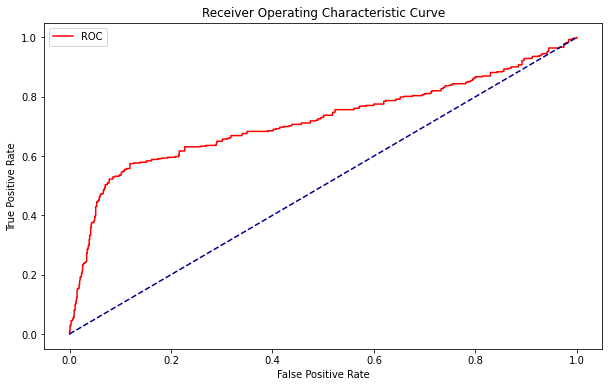

In [775]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

<br>

## Normalized Confusion Matrix

<br>

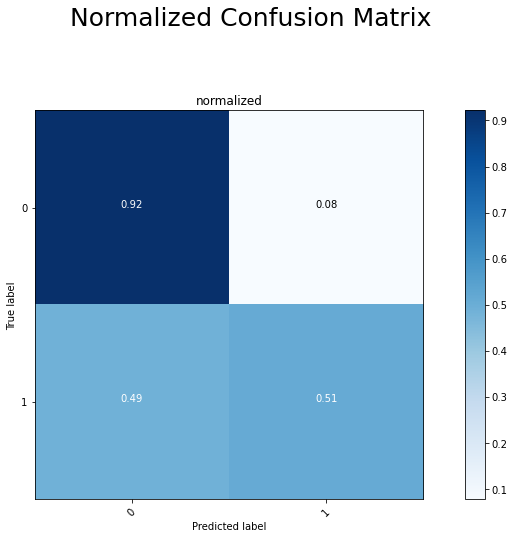

In [776]:
fig = plt.figure(figsize=(10,8))
fig.set_figwidth(15)
fig.suptitle('Normalized Confusion Matrix', fontsize=25, x=0.585)
fig.subplots_adjust(top=0.8)

def confusion_matrix_plotter(test_observations, predicted, pane_title):
    cnf_matrix = confusion_matrix(test_observations, predicted)
    np.set_printoptions(precision=2)
    cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(pane_title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0, 1], rotation=45)
    plt.yticks(tick_marks, [0, 1])
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
confusion_matrix_plotter(y_test, y_pred, 'normalized')

for i in range(4):
    print()

<br>

### II G) Statistical Summary

<br>

The confusion matrix does not show a high-performing model.  It is not expected to because patient outcomes are, by their nature hard to anticipate.  But the information that it does provide is valuable.  Of prime importance is the lower right and corner where the predicted and true labels are both 1 showing that, for a particular set of high risk patients, there is a 57% chance of death.  This is worse than most games of Russian roulette.

<br>

### III Conclusions

<br>